In [1]:
import numpy as np
import sqlite3
import polars as pl
from matplotlib import pyplot as plt

In [2]:
db_path = "../db/mygo.db"
conn = sqlite3.connect(db_path)
conn.execute("SELECT 1").fetchall()

[(1,)]

In [3]:
df = pl.read_database(
    """
    SELECT
        episode,
        frame_number,
        role,
        subtitle
    FROM 
        storyboards 
    ORDER BY 
        episode, 
        frame_number                
""",
    connection=conn,
)
df.head()

episode,frame_number,role,subtitle
i64,i64,str,str
1,758,"""爽世""","""小祥"""
1,801,"""爽世""","""太好了 妳終於來了"""
1,855,"""爽世""","""怎麼濕成這樣 妳沒事吧"""
1,923,"""爽世""","""妳最近不來學校 發消息也不回"""
1,1031,"""祥子""","""今天我來是有話要說"""


In [4]:
fn_diff = pl.concat(
    [
        episode_df.select(fn_diff=pl.col("frame_number").diff().fill_null(0))
        for _, episode_df in df.group_by("episode")
    ]
)["fn_diff"]
fn_diff

fn_diff
i64
0
44
68
73
76
…
59
163
87


In [5]:
bin_count = 500
fn_diff_hist = (fn_diff + 1).log1p().hist(bin_count=bin_count)
fn_diff_hist.head()

breakpoint,category,count
f64,cat,u32
0.708958,"""(0.685242, 0.708958]""",15
0.724768,"""(0.708958, 0.724768]""",0
0.740579,"""(0.724768, 0.740579]""",0
0.756389,"""(0.740579, 0.756389]""",0
0.7722,"""(0.756389, 0.7722]""",0


In [6]:
fn_pdf = fn_diff_hist["count"] / fn_diff_hist["count"].sum()
fn_cdf = np.cumsum(fn_pdf.to_numpy())

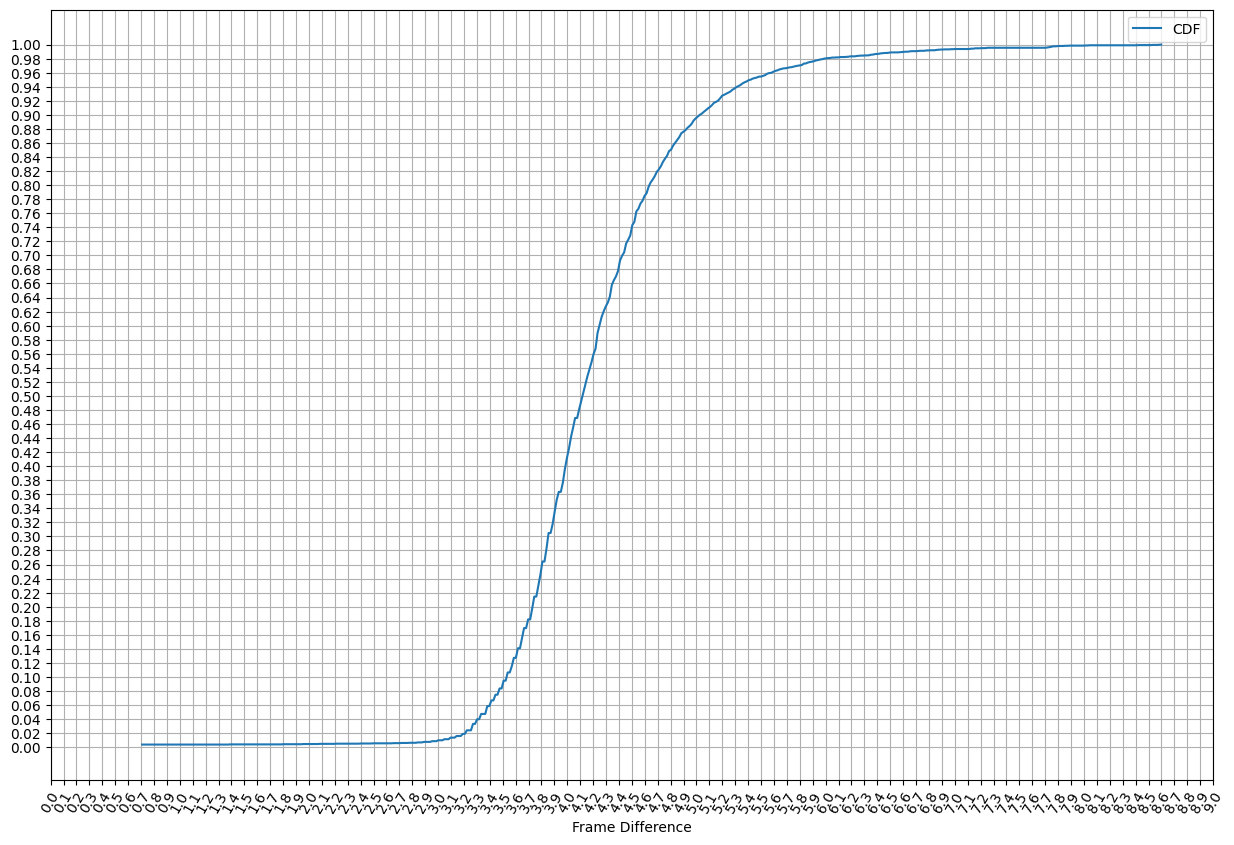

In [7]:
plt.figure(figsize=(15, 10))
plt.plot(fn_diff_hist["breakpoint"].to_numpy(), fn_cdf, label="CDF")
plt.xlabel("Frame Difference")
plt.xticks(np.arange(0, 9.1, 0.1), rotation=60)
plt.yticks(np.arange(0, 1.02, 0.02))
plt.grid()
plt.legend()
plt.show()

In [8]:
np.exp(5.8)

np.float64(330.2995599096486)